# Pysersic Walkthrough: Fitting a single source

In this tutorial we'll walk through how to set up and fit a galaxy using `pysersic`. 

## Loading the data

We'll be using three galaxies imaged by HSC for this example. The 4 needed inputs to perform a fit are
 - im: the image itself
 - mask: a mask indicating pixels which should not be included in the fit
 - sig: a map of pixel uncertainties 
 - psf: a map of the PSF (for now, only one psf can be used).

In [1]:
import numpy as np 
def load_data(n):
    im = np.load(f'examp_gals/gal{n}_im.npy')
    mask = np.load(f'examp_gals/gal{n}_mask.npy')
    sig = np.load(f'examp_gals/gal{n}_sig.npy')
    psf = np.load(f'examp_gals/gal{n}_psf.npy')
    return im,mask,sig,psf 

im,mask,sig,psf = load_data(2)

Let's visualize our galaxy, just to see what we're working with. You can do this any way you like. A convenience function is provided:

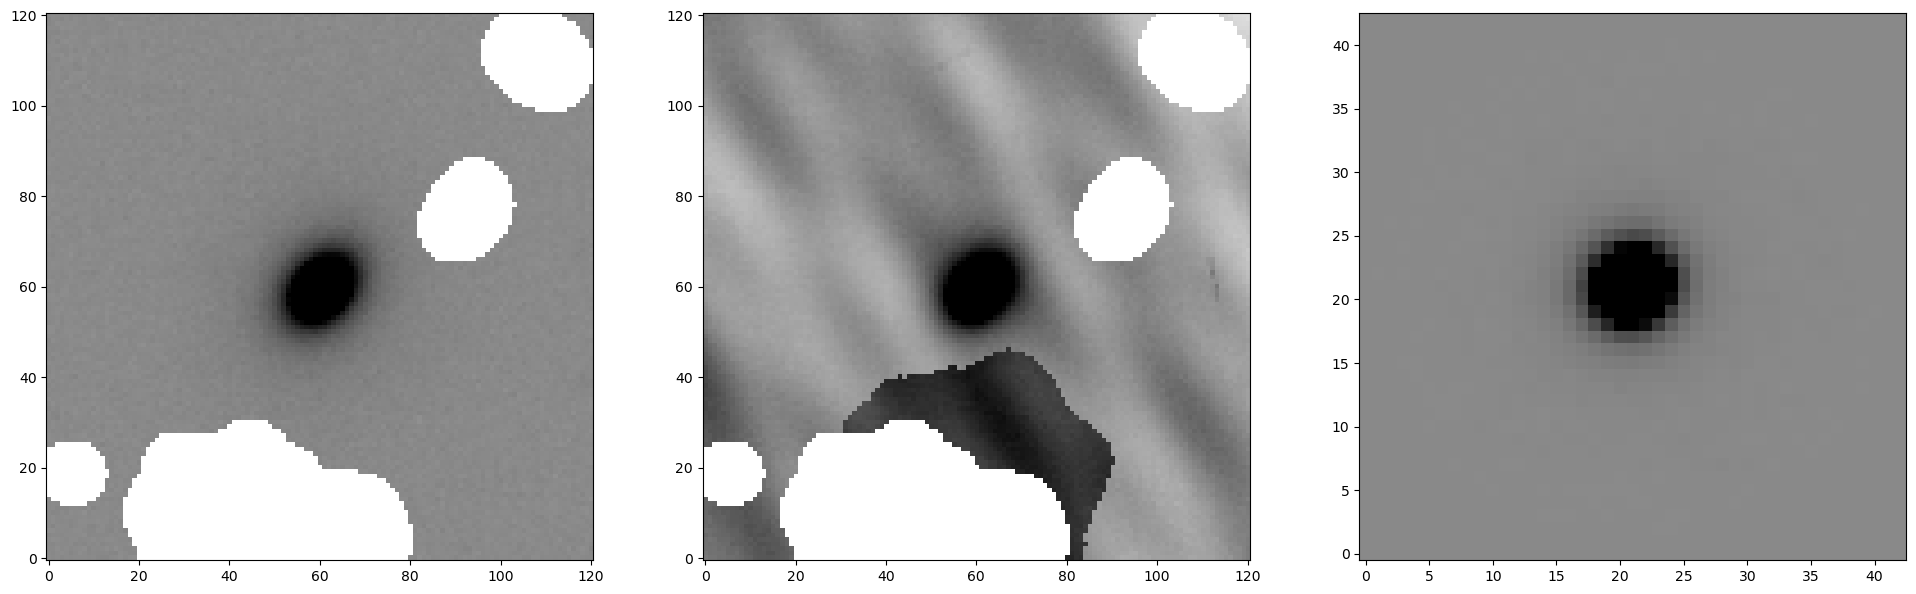

In [2]:
from pysersic.results import plot_image

fig, ax = plot_image(im,mask,sig,psf)

We can also check that our inputs --- the image, mask, rms map, and psf --- conform to the necessary shapes and sizes for a `pysersic` run. 

In particular, our `psf` map must be smaller than the input data image, and the data, rms, and mask (if provided) must have the same shape.

The `pysersic` code will automatically check your input data for goodness when it runs, but if you would like to check before attempting to run `pysersic`, you can do so via the following:


In [3]:
from pysersic import check_input_data

check_input_data(data=im,rms=sig,psf=psf,mask=mask)

True

This function will return `True` if all checks pass, otherwise it will raise a warning or exception if something is amiss. 

## Fitting 

Now that we have our galaxy to fit, we can get set up with `pysersic`. 

Because we are fitting a single source, we'll want to initialize a `pysersic.FitSingle` object. For a field with multiple object, we would use `pysersic.FitMulti`. 

Additionally, we will need to set up a `pysersic.PysersicSourcePrior` object to handle the priors for the fit. (Again, using Source as we have a single galaxy to fit). 



The Source Prior takes two initial arguments, the profile type, whose options at current are
- sersic
- pointsource
- exponential
- devaucoleurs

and two compound profiles
- doublesersic (2 sersic profiles with a shared center and PA)
- sersic_pointsource (shared center)


and the sky_type, which indicates whether to fit the sky background, either with
- none (no fitting)
- flat (constant offset), or 
- tilted-plane 

At this point, we would need to write down priors for all of the fit parameters of a Sersic. However, there is an `autoprior` function that measures the observed properties of the source using the `photutils` package to help us with this:


In [4]:
from pysersic.priors import autoprior

prior  = autoprior(image = im, profile_type = 'sersic', mask=mask, sky_type = 'none')

The `generate_prior()` function has a built-in choices about the prior functions to use for each sersic parameter based off of the observed properties. These seem to work decently well in a lot of cases we tested but may not work for you! We can also specify if we want to add a sky model, here we will not. To see more about customizing priors, see the manual-priors example notebook or the documentation. For now we will print our prior:

In [5]:
prior

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 3689.19, sigma = 121.48
xc ---  Normal w/ mu = 60.39, sigma = 1.00
yc ---  Normal w/ mu = 59.29, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 6.16, sigma = 4.96, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.65 -> 8.00
sky type - None

As we can see, this function used properties of the input image to make reasonable priors for the fit parameters. For now, let's continue, and in another example, we'll set some priors manually. 

Armed with our prior object, we can set up our `FitSingle` fitter. At this stage, we need to choose a `loss_func()`, which is used to evaluate the models to the data. For this example, we'll import the `student_t_loss()` from the `utils.loss` submodule. This is a decent starting place  as it is less sensitive to outliers than a gaussian (i.e. $\chi^2$) loss.

In [6]:
from pysersic import FitSingle
from pysersic.loss import student_t_loss

fitter = FitSingle(data=im,rms=sig,mask=mask,psf=psf,prior=prior,loss_func=student_t_loss)

There are a set of currently loss functions already coded up in loss py, some of which include:
- Cash loss using Poisson Statistics(Cash 1979)
- Gaussian loss with a free systematic scatter parameter
- Gaussian mixture loss with representing an outlier distribution

See the page on `Loss Functions` to learn more about these choices. 

With a fitter object created, we are now free to carry out a fit. 

## MAP Parameters
Before we jump all the way into *sampling*, it's worth noting that we can also retrieve a prediction for the best fit model very quickly, using SVI (stochastic variational inference). 

The simplest, barebones way to do this is to run the `fitter.find_MAP()` method. This will produce a point-estimate of the parameters with no attempt to estimate the posterior distribution (i.e., the closest thing to running GALFIT). Unlike the rest of the methods we'll show below, this does not produce a fancy `PySersicResult` object; it simply returns a dictionary with the values:

In [7]:
map_params = fitter.find_MAP()

  1%|▏         | 254/20000 [00:00<00:28, 681.41it/s, Round = 2,step_size = 5.0e-04 loss: -1.537e+04]


In [8]:
map_params

{'flux': Array(3756.8572, dtype=float32),
 'xc': Array(60.43686, dtype=float32),
 'yc': Array(59.251778, dtype=float32),
 'r_eff': Array(6.25729, dtype=float32),
 'ellip': Array(0.31228, dtype=float32),
 'theta': Array(4.01473, dtype=float32),
 'n': Array(3.6415, dtype=float32),
 'model': array([[0.0042142 , 0.00437077, 0.00454337, ..., 0.00095188, 0.00091831,
         0.00087599],
        [0.00433631, 0.00451275, 0.00468318, ..., 0.00099256, 0.00094703,
         0.0009153 ],
        [0.0044711 , 0.00464515, 0.00483604, ..., 0.00102434, 0.00098898,
         0.00094516],
        ...,
        [0.00086171, 0.00090247, 0.00093421, ..., 0.00477017, 0.0045884 ,
         0.00442312],
        [0.0008356 , 0.00086418, 0.0009067 , ..., 0.00461194, 0.0044512 ,
         0.00428329],
        [0.00080011, 0.00083957, 0.00086992, ..., 0.00446865, 0.00430547,
         0.00415776]], dtype=float32)}

We can then use the `plot_residual` function to quickly compare model to the data:

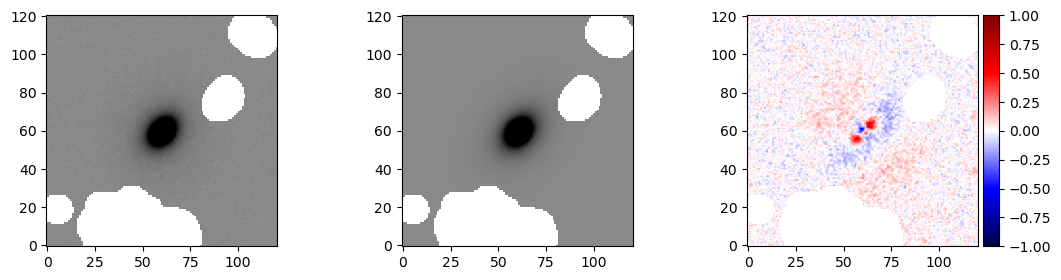

In [12]:
from pysersic.results import plot_residual
fig, ax = plot_residual(im,map_params['model'],mask=mask,vmin=-1,vmax=1)

Without compilation (i.e., after being run once), running this took ~3 seconds on the laptop on which this notebook was run (on CPU). Including compilation, it is closer to ~5s. 

## Posterior *Estimation*

Taking one step up from simply retrieving the MAP, we can make an *estimate* of the posterior around the MAP using one of several available methods. 

At present, these are `laplace`, in which the MAP is found, then the posterior is assumed to be a gaussian around it, and `svi-flow`, in which a normalizing flow is trained to estimate the posterior and is sampled from directly. 

Both methods are relatively fast, with `laplace` taking 8-10 seconds and `svi-flow` taking around 45 seconds. 


In [9]:
res = fitter.estimate_posterior(method='laplace')

  1%|▏         | 268/20000 [00:00<00:27, 705.42it/s, Round = 2,step_size = 5.0e-04 loss: -1.536e+04]


In [10]:
res2 = fitter.estimate_posterior(method='svi-flow')

  3%|▎         | 612/20000 [00:04<02:27, 131.49it/s, Round = 2,step_size = 5.0e-04 loss: -1.534e+04]


As a note, these fit methods return the results object, but we can access it anytime by calling the `fitter.svi_results` attribute. But a given `fitter` can only have one `svi_results` and one `sampling_results` at a time, hence the use of `res2` above to extract it separately

For any run, we can use the `.summary()` method of the `fitter.svi_results` to see a dataframe output.

In [11]:
fitter.svi_results.summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ellip,0.312,0.002,0.309,0.316,0.000,0.000,803.0,820.0,NaN
flux,3757.325,8.179,3741.640,3772.504,0.267,0.189,935.0,800.0,NaN
n,3.644,0.021,3.601,3.681,0.001,0.001,838.0,629.0,NaN
r_eff,6.258,0.026,6.209,6.304,0.001,0.001,921.0,830.0,NaN
theta,0.873,0.003,0.867,0.879,0.000,0.000,1021.0,908.0,NaN
xc,60.437,0.003,60.430,60.443,0.000,0.000,968.0,884.0,NaN
yc,59.253,0.004,59.246,59.259,0.000,0.000,1018.0,956.0,NaN


## Sampling 

Let's now try to sample. Here, we use the efficiency of No U-turn sampling plus the jit-compiled nature of the codebase to generate e.g., 4000 samples relatively quickly (<1 min per chain).

We can run the `fitter.sample()` method with no arguments, which will default to 2000 samples in 2 chains. But `sample()` will take any `**kwargs` to be passed to the `mcmc.NUTS()` sampler under the hood. The `fitter.sample()` method returns a new instance of a `PySersicResults` object, but will also store that new result in an attribute `fitter.sampling_results`, so we don't explicitly have to define a name here:

In [13]:
fitter.sample()

/Users/timothymiller/Documents/research/packages/pysersic/pysersic/pysersic/pysersic.py:138: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler =infer.MCMC(infer.NUTS(model,init_strategy=init_strategy, **sampler_kwargs),num_chains=num_chains, num_samples=num_samples, num_warmup=num_warmup,  **mcmc_kwargs)
sample: 100%|██████████| 2000/2000 [00:37<00:00, 53.07it/s, 15 steps of size 2.11e-01. acc. prob=0.94]


PySersicResults object for pysersic fit of type: sampling

If we want to see the reuslts, we can retrieve an arviz summary table the same way as before, but this time retrieving the sampling results:

In [14]:
sampling_res = fitter.sampling_results
sampling_res.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ellip,0.312,0.002,0.309,0.316,0.000,0.000,1562.0,1374.0,1.00
flux,3757.448,8.451,3740.101,3771.886,0.275,0.195,944.0,1091.0,1.01
n,3.643,0.023,3.599,3.684,0.001,0.001,966.0,1198.0,1.00
r_eff,6.258,0.027,6.205,6.305,0.001,0.001,995.0,1077.0,1.00
theta,0.873,0.003,0.867,0.879,0.000,0.000,2576.0,1634.0,1.00
xc,60.437,0.003,60.430,60.443,0.000,0.000,1668.0,1209.0,1.00
yc,59.252,0.004,59.245,59.259,0.000,0.000,1894.0,1405.0,1.00


## Other Diagnostics and Visualizations

Below we cover a few diagnostics we can look at. 

We can, for example, create corner plots for either the SVI results or sampling results:

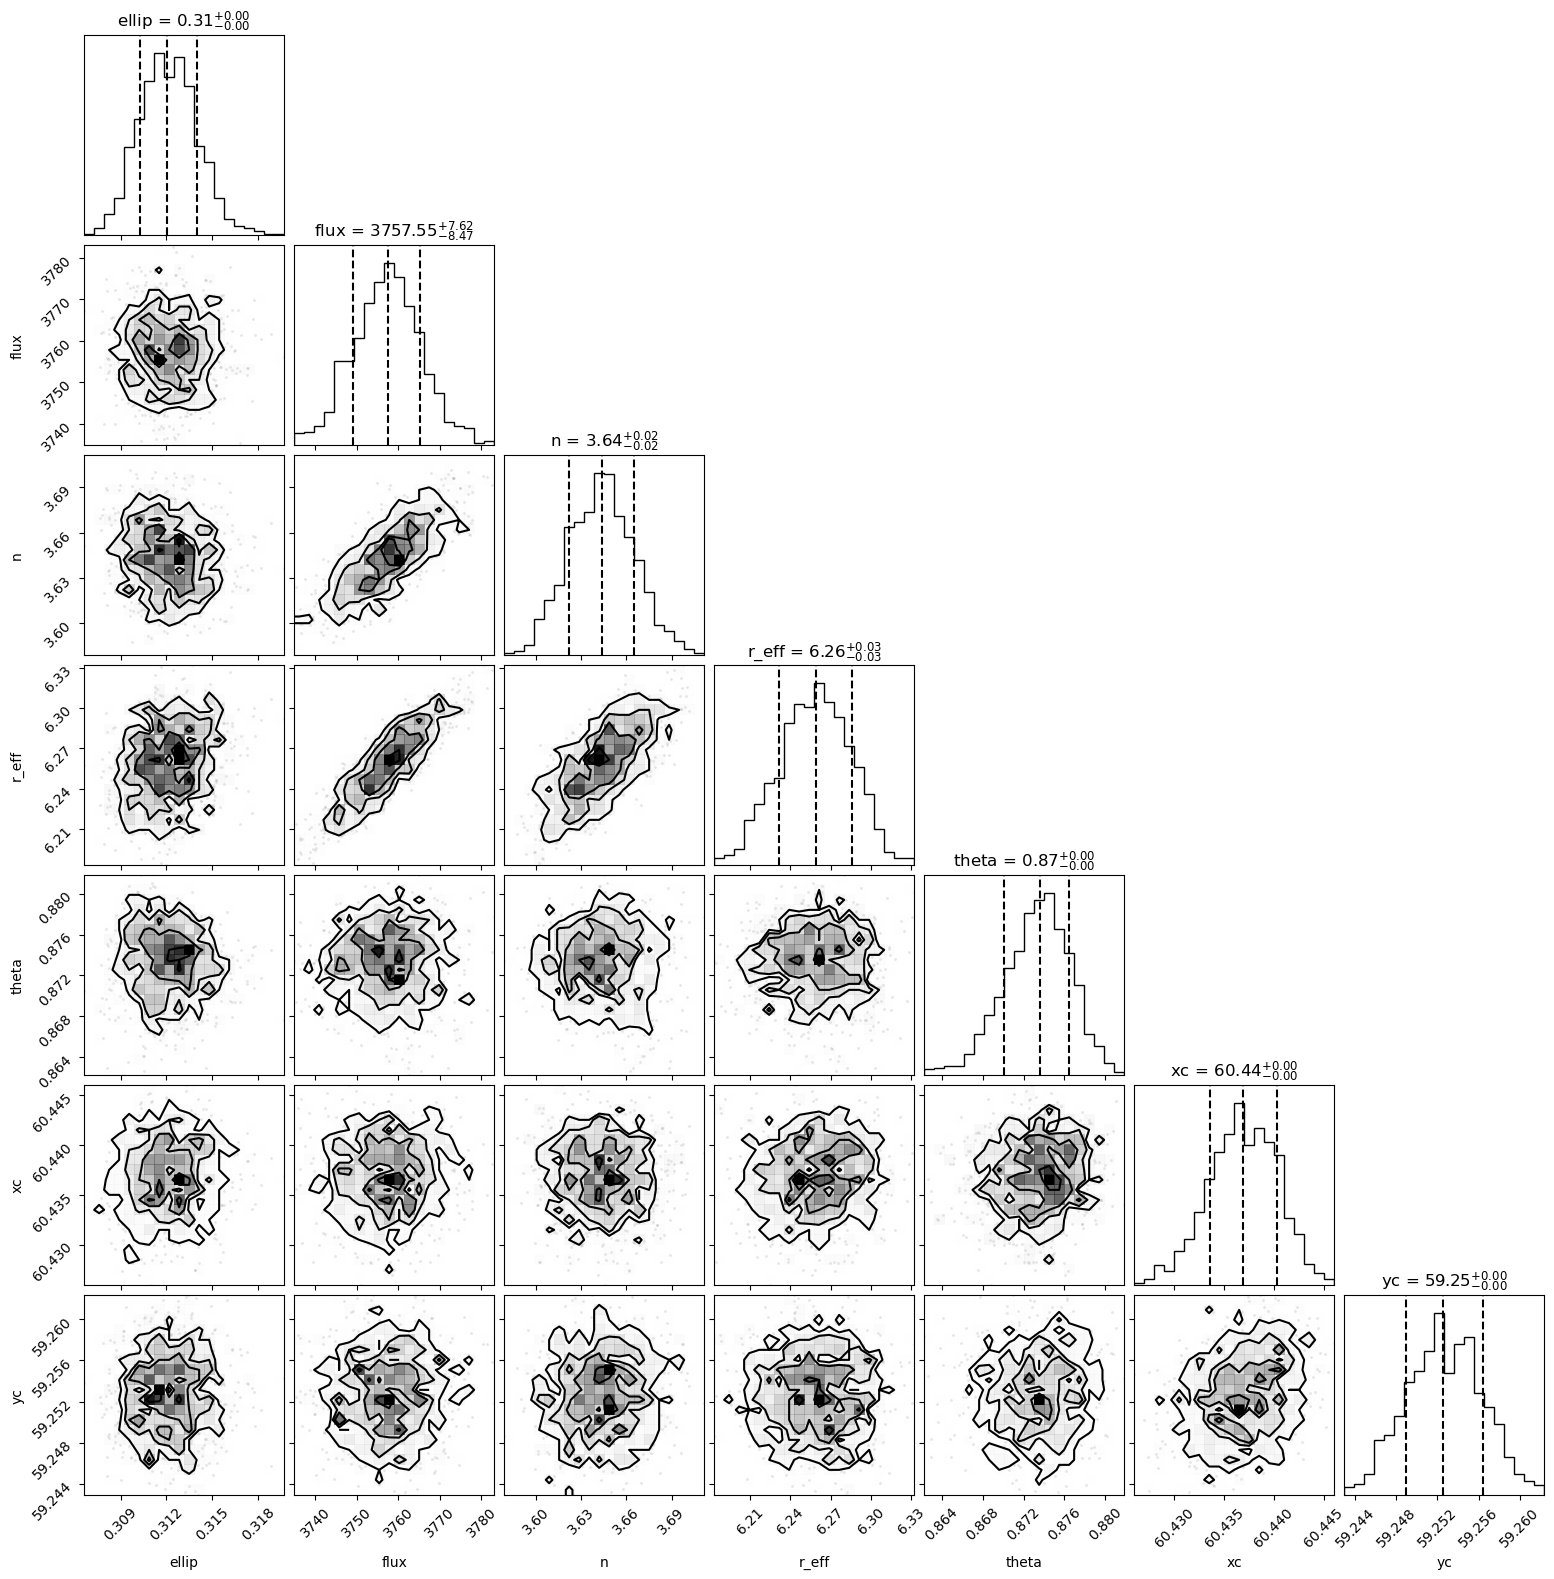

In [15]:
fig = fitter.svi_results.corner()

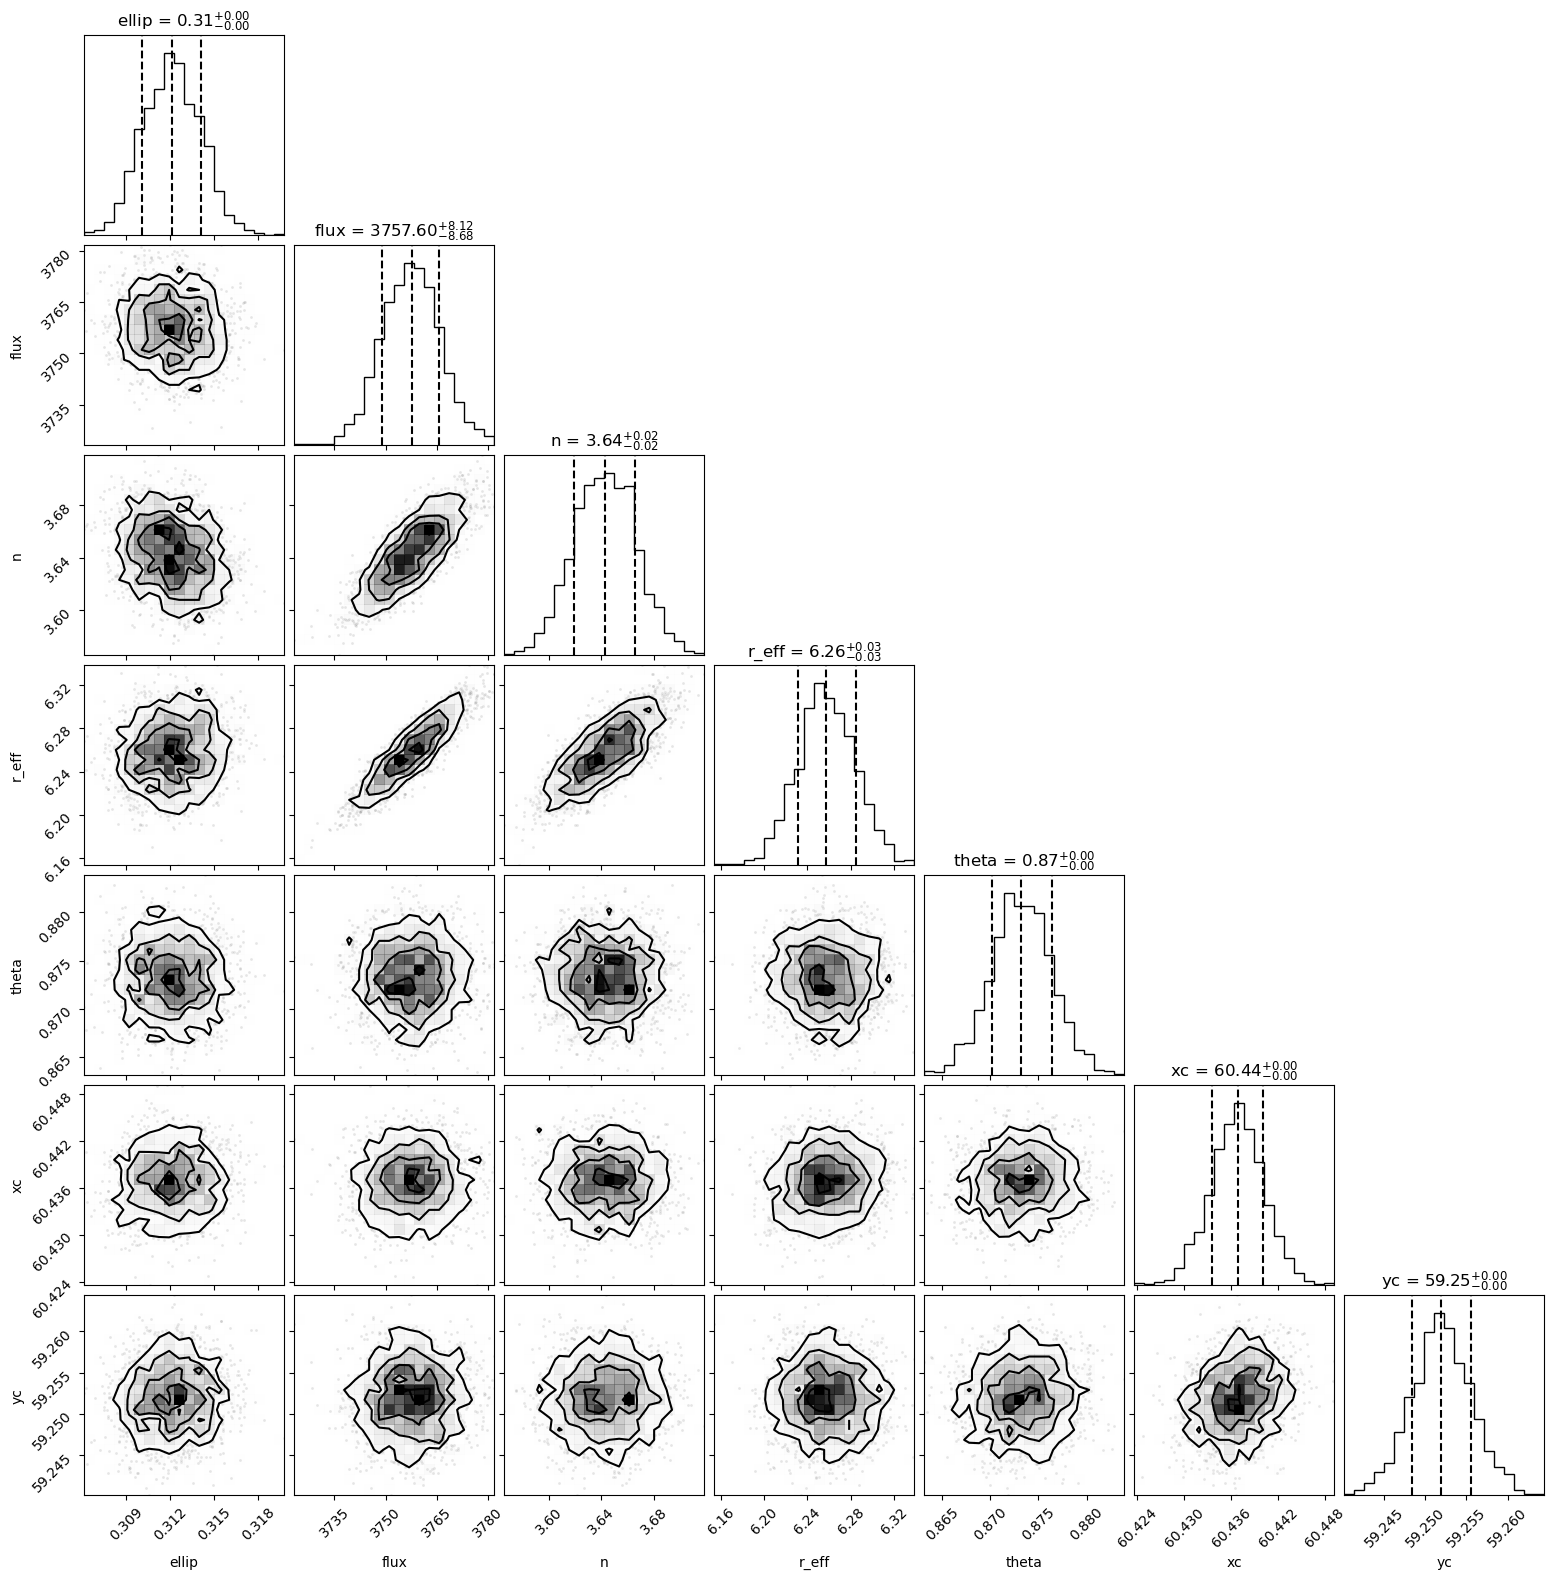

In [16]:
fig = fitter.sampling_results.corner()

It is relatively easy with the `corner.py` package to overplot both on each other to see how similar they are:

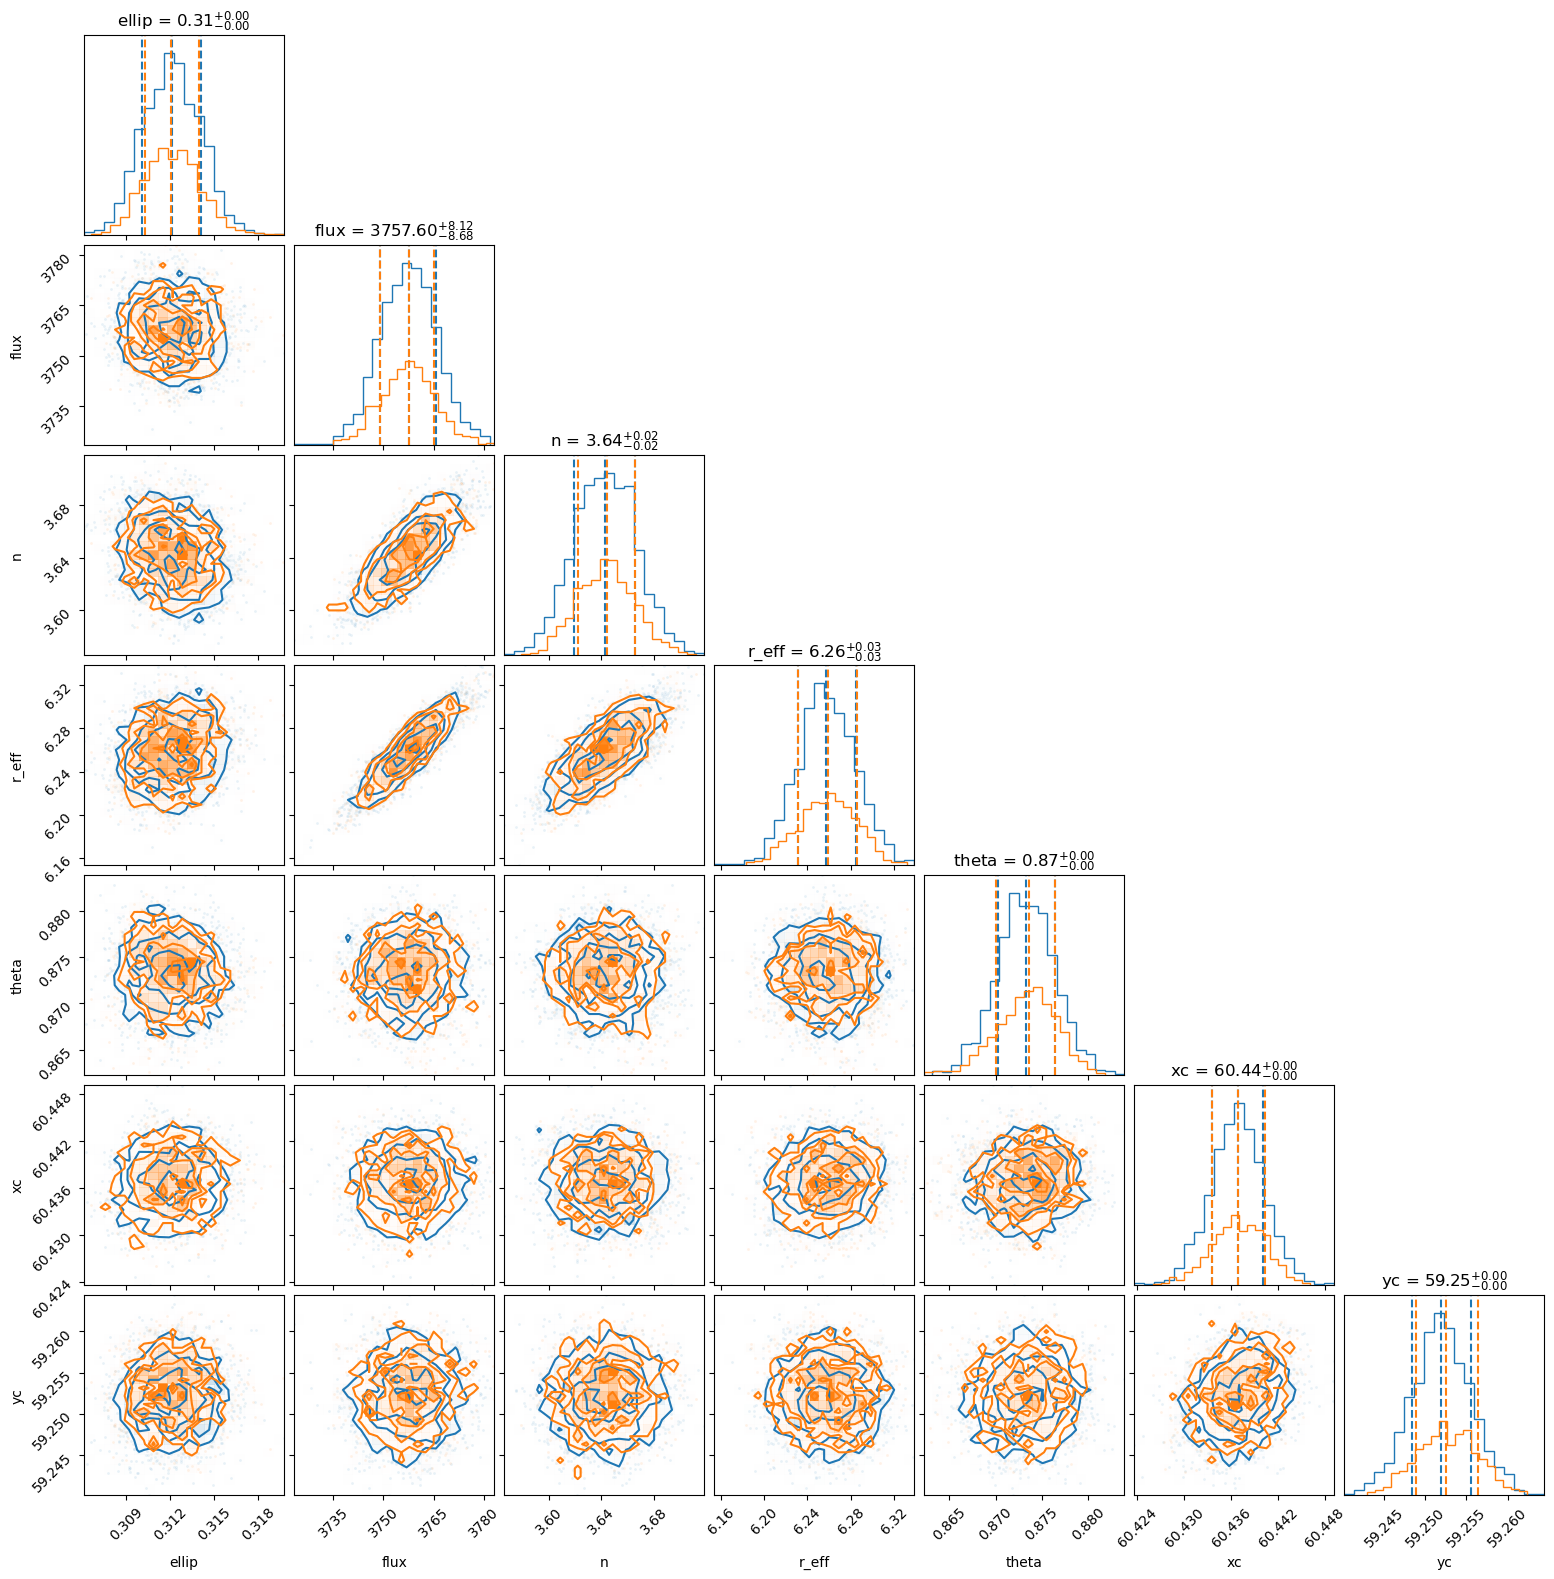

In [17]:
import corner 
fig = fitter.sampling_results.corner(color='C0') 
fig = corner.corner(fitter.svi_results.idata,quantiles=[.16,.5,.84],color='C1',fig=fig)


If we want to retrieve a table with arbitrary quantiles for a fit, we can use the `retrieve_param_quantiles()` function. This will return either a dictionary (if `return_dataframe=False`) or a data frame, with the requested quantiles as columns and the parameters as rows.

In [18]:
fitter.svi_results.retrieve_param_quantiles(return_dataframe=True)

,0.16,0.50,0.84
ellip,0.310288,0.312063,0.313986
flux,3749.074580,3757.549561,3765.166631
n,3.621942,3.643909,3.665334
r_eff,6.231373,6.259202,6.285951
theta,0.870091,0.873566,0.876396
xc,60.433567,60.436924,60.440343
yc,59.248899,59.252512,59.256445


In [19]:
fitter.svi_results.retrieve_param_quantiles(return_dataframe=False)

{'ellip': [0.3102883863449097, 0.31206265091896057, 0.31398645520210267],
 'flux': [3749.074580078125, 3757.549560546875, 3765.166630859375],
 'n': [3.6219419193267823, 3.643909454345703, 3.6653336811065675],
 'r_eff': [6.231372585296631, 6.259202480316162, 6.285950565338135],
 'theta': [0.8700911903381348, 0.8735661506652832, 0.8763964653015137],
 'xc': [60.43356704711914, 60.43692398071289, 60.440342559814454],
 'yc': [59.24889892578125, 59.252511978149414, 59.25644546508789]}

As a note, the default returned quantiles are `[0.16, 0.5, 0.84]` but you can specify any quantiles you wish to the method. The same syntax above will work with the `fitter.sampling_results` as well --- they are the same underlying class.

In [20]:
fitter.sampling_results.retrieve_param_quantiles(return_dataframe=True)

,0.16,0.50,0.84
ellip,0.310101,0.312142,0.314120
flux,3748.927217,3757.603027,3765.722588
n,3.619480,3.642741,3.665881
r_eff,6.231431,6.257566,6.284726
theta,0.870221,0.873239,0.876364
xc,60.433544,60.436890,60.440152
yc,59.248400,59.251974,59.255553


We can also print out a latex-ready table (using the AAStex deluxetable), if we would so like (the data portion of the table is easily copy-able to other formats).

In [21]:
fitter.sampling_results.latex_table()

\begin{deluxetable}{lr}[b]
\tablehead{
\colhead{Parameter} & \colhead{\hspace{4.5cm}Value\hspace{.5cm}}}
\caption{Best Fit Parameters for Pysersic Fit}
\startdata 
ellip & 0.312_{-0.002}^{+0.002} \\ 
flux & 3757.603_{-8.676}^{+8.120} \\ 
n & 3.643_{-0.023}^{+0.023} \\ 
r_{\rm eff} & 6.258_{-0.026}^{+0.027} \\ 
\theta & 0.873_{-0.003}^{+0.003} \\ 
xc & 60.437_{-0.003}^{+0.003} \\ 
yc & 59.252_{-0.004}^{+0.004} \\ 
\enddata 
\end{deluxetable}


We can also use any callable `func` on any parameter via the following:

In [22]:
ellip_std = fitter.sampling_results.compute_statistic(parameter='ellip',func=np.std)
ellip_std

array(0.00194962, dtype=float32)

Finally, if we just want to yank the chains and start doing our own thing with them, note that the results object has an attribute `.idata` which is an `arviz.InferenceData` object, so it can be slotted into many analyses. We do have a handy function for extracting the chains for each parameter, though:

In [23]:
sampling_chain = fitter.svi_results.get_chains()
sampling_chain['n']

<xarray.DataArray 'n' (sample: 1000)>
array([3.6685736, 3.6505914, 3.6369987, 3.6585262, 3.6426234, 3.6589735,
       3.6644702, 3.6297507, 3.6422367, 3.6264975, 3.638409 , 3.6824148,
       3.6386957, 3.6916637, 3.665794 , 3.6397884, 3.578855 , 3.6229417,
       3.617238 , 3.6461952, 3.6175644, 3.6476986, 3.6742067, 3.6715853,
       3.6147225, 3.6340919, 3.6408882, 3.6589513, 3.6671648, 3.6696289,
       3.6207244, 3.674071 , 3.666244 , 3.6594055, 3.6517663, 3.6189756,
       3.6725008, 3.6397934, 3.6453547, 3.6297462, 3.6344454, 3.6166706,
       3.6524196, 3.630024 , 3.6071   , 3.624671 , 3.6496775, 3.6661468,
       3.6427352, 3.6470177, 3.6604729, 3.6281714, 3.6236386, 3.640313 ,
       3.645018 , 3.5933182, 3.6529622, 3.616029 , 3.6455855, 3.6642613,
       3.6568108, 3.6474876, 3.6451309, 3.6260402, 3.6370885, 3.6214533,
       3.6511626, 3.649854 , 3.6543932, 3.6236897, 3.6107204, 3.642435 ,
       3.6152477, 3.6290658, 3.6448553, 3.6569   , 3.6426225, 3.619474 ,
       3.6087608, 3.651137 , 3.6890483, 3.6623564, 3.686829 , 3.6868708,
       3.6620216, 3.6810756, 3.6225898, 3.6682837, 3.6343503, 3.656584 ,
       3.6220734, 3.6439047, 3.6163538, 3.6094952, 3.6488771, 3.623646 ,
       3.6334865, 3.6369374, 3.6370463, 3.6609507, 3.6140697, 3.6158857,
       3.6013246, 3.594062 , 3.6134531, 3.6093857, 3.6775842, 3.6183136,
       3.676971 , 3.6725163, 3.660665 , 3.6273553, 3.6488621, 3.6573994,
       3.6163583, 3.6469088, 3.597931 , 3.6202562, 3.6717963, 3.6412516,
...
       3.645867 , 3.6181479, 3.6666481, 3.6561868, 3.6438186, 3.6648524,
       3.641092 , 3.6561484, 3.6335428, 3.6412144, 3.6296115, 3.6431315,
       3.647583 , 3.6242583, 3.635205 , 3.6637676, 3.6598692, 3.6542826,
       3.6501234, 3.634373 , 3.6353724, 3.6436727, 3.6318913, 3.610559 ,
       3.6516354, 3.6375697, 3.6471634, 3.6542268, 3.6240613, 3.6295469,
       3.6505294, 3.6390462, 3.6541297, 3.6218064, 3.6830645, 3.7013738,
       3.6026306, 3.6797132, 3.6837971, 3.608892 , 3.6306884, 3.6604347,
       3.6355076, 3.665198 , 3.6406608, 3.6456692, 3.6044858, 3.6469772,
       3.651179 , 3.6520185, 3.61291  , 3.652985 , 3.635224 , 3.639429 ,
       3.6409366, 3.6492717, 3.6486804, 3.6691878, 3.6453097, 3.6424806,
       3.6244564, 3.619495 , 3.644314 , 3.6359818, 3.6558344, 3.623406 ,
       3.6397913, 3.625475 , 3.6607199, 3.6726055, 3.6303   , 3.699501 ,
       3.6800091, 3.619318 , 3.640839 , 3.6223376, 3.6752534, 3.6450634,
       3.6832175, 3.5987113, 3.6683843, 3.6371968, 3.6568277, 3.652499 ,
       3.6351376, 3.6233754, 3.6370747, 3.670448 , 3.6196244, 3.64839  ,
       3.6248682, 3.670141 , 3.621821 , 3.6257398, 3.6519232, 3.7116225,
       3.6453035, 3.6633208, 3.6434174, 3.654946 , 3.6417425, 3.6269493,
       3.6070902, 3.668963 , 3.6459308, 3.6413355, 3.6316333, 3.6240118,
       3.643773 , 3.6369433, 3.649351 , 3.6441448, 3.6556432, 3.642643 ,
       3.6629088, 3.657667 , 3.6563241, 3.6420174], dtype=float32)
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

There are many more things we can do in terms of carrying out statistics on our outputs -- but since `arviz` has its own, well-vetted system for that, we trust that you can grab the `arviz` inference data objects (`fitter.svi_results.idata` and `fitter.sampling_results.idata`) and run with them as needed, inserting them into other analyses.



## Saving the fit to a file 

Lastly, we may want to save the parameters of our fit (info, chains, models, data) to a file. This can be done with the `results.save_results()` method:

As we can see, the information needed to reconsitute the models and fit parameters are all stored in this file. The `'input_data'` dictionary in the tree contains a copy of the data that was fit. We can see which loss function and renderer was used. We can also access our prior printout:

In [24]:
fitter.sampling_results.save_result('example_fit.asdf')

RecursionError: maximum recursion depth exceeded while calling a Python object

We can (presumably at a later time) then load our asdf file and view what it contains:

In [25]:
import asdf 
af = asdf.open('example_fit.asdf')
af.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.12.0
├─history (dict)
│ └─extensions (list) ...
├─best_model (NDArrayType): shape=(121, 121), dtype=float32
├─best_model_params (dict)
│ ├─ellip (float): 0.31033268570899963
│ ├─flux (float): 3752.096435546875
│ ├─n (float): 3.654308795928955
│ ├─r_eff (float): 6.250426769256592
│ ├─theta (float): 0.8742525577545166
│ ├─xc (float): 60.433258056640625
│ └─yc (float): 59.254512786865234
├─input_data (dict) ...
├─loss_func (str): <function student_t_loss at 0x7fd0f4014670>
├─method_used (str): sampling
├─posterior (dict) ...
├─prior_info (str): Prior for a sersic source:
--------------------------
flux ---  Normal w (truncated)
└─renderer (str): <pysersic.rendering.HybridRenderer object at 0x7fd0e46446d0>
Some nodes not shown.


As we can see, everything we need, from the input data, to which loss function, to the prior info, and finally the posterior chains, are stored in this file. For example, to see what our priors were:

In [26]:
print(af.tree['prior_info'])

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 3689.19, sigma = 121.48
r_eff ---  Truncated Normal w/ mu = 6.16, sigma = 4.96, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Uniform between: 0.65 -> 8.00
xc ---  Normal w/ mu = 60.39, sigma = 1.00
yc ---  Normal w/ mu = 59.29, sigma = 1.00

Sky Type: none



And finally, the posterior chains for the fits are in the `'svi_posterior'` and `'sampling_posterior'` dictionaries within the tree. As a result, we can quickly re-constitute a corner plot:

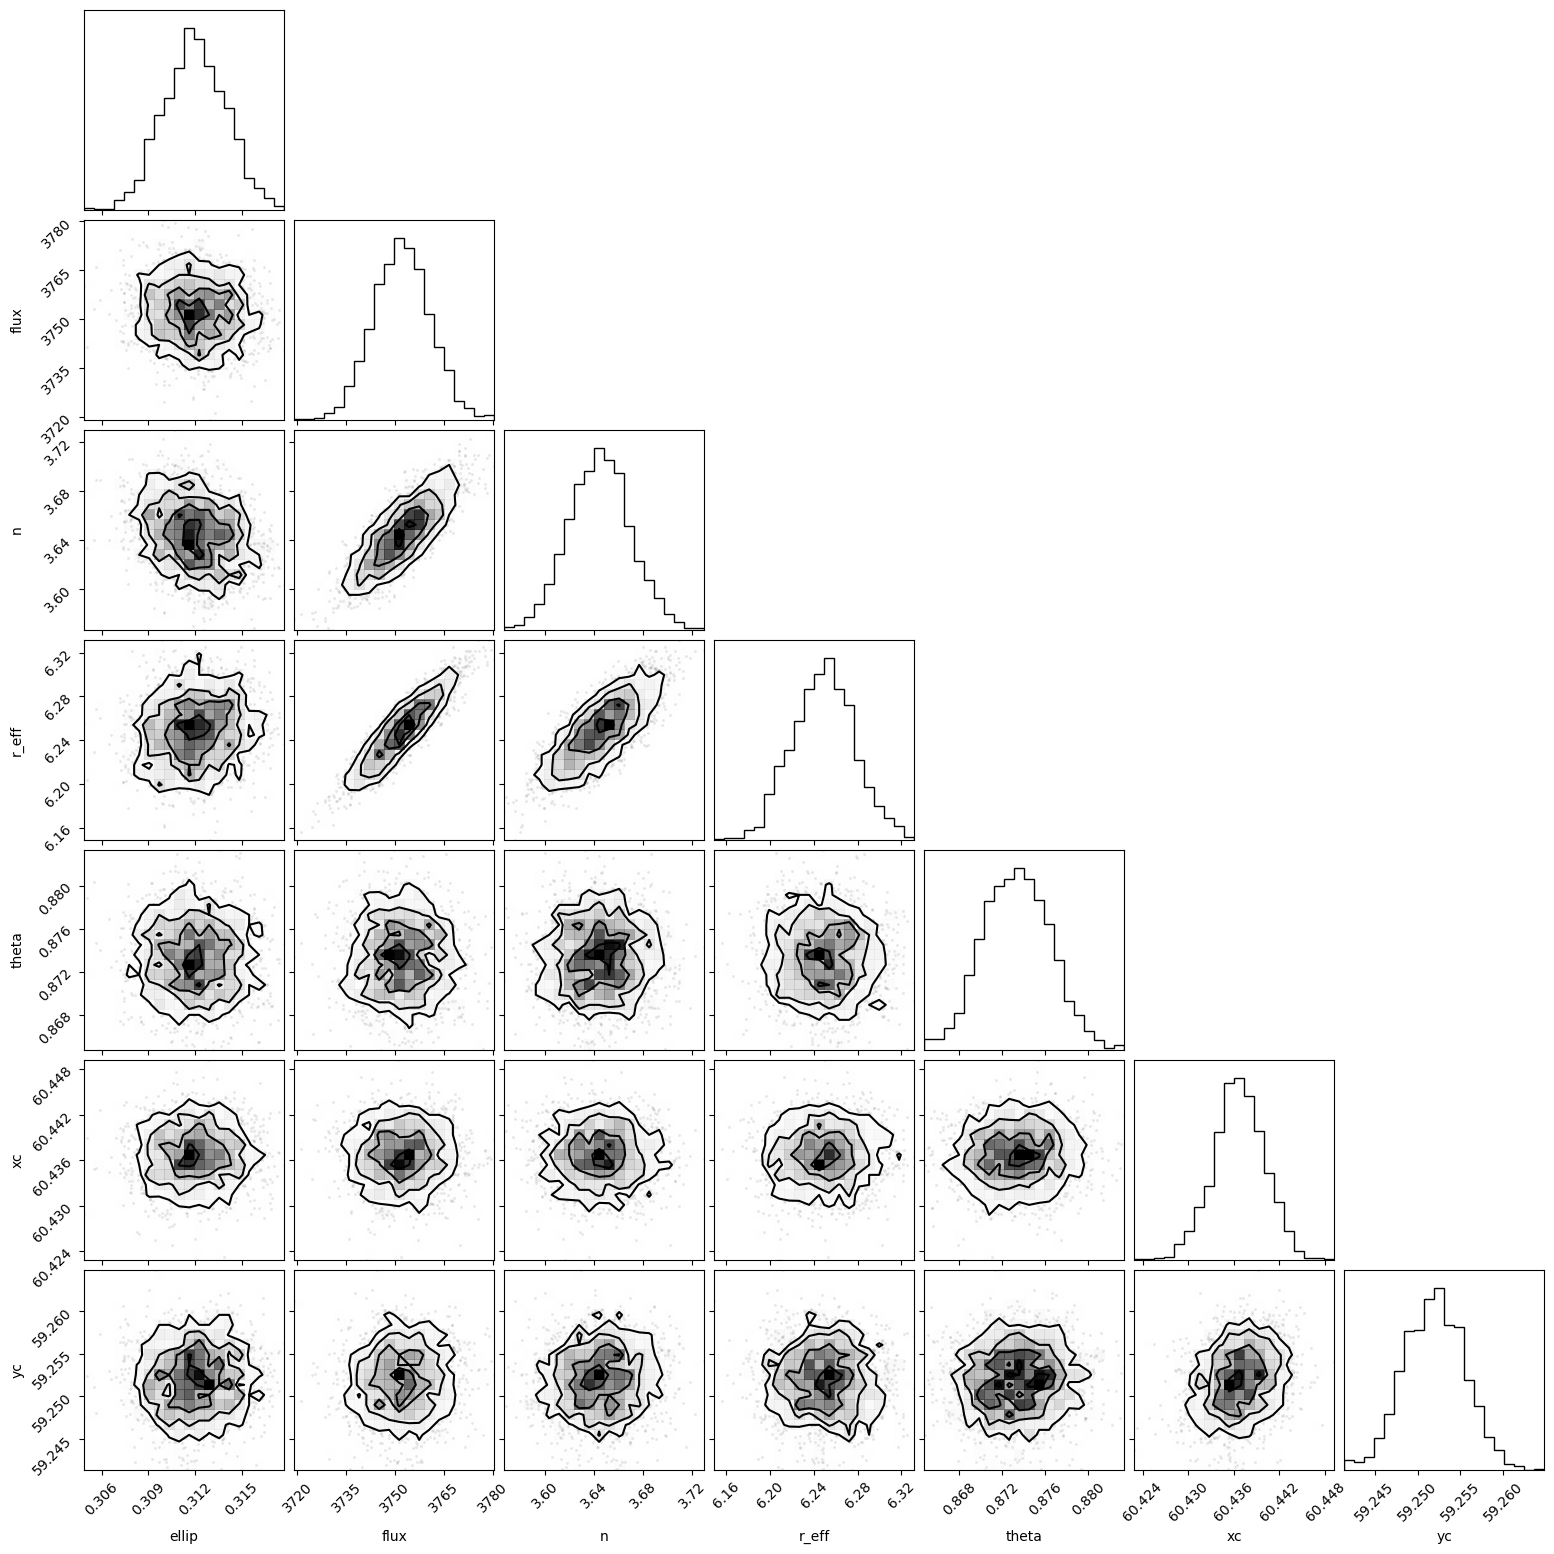

In [27]:
import corner 
fig = corner.corner(af.tree['posterior'])